In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from sklearn.metrics import f1_score 
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D

In [2]:
# Loads the data required for detecting the license plates from cascade classifier.
plate_cascade = cv2.CascadeClassifier('../weights/indian_license_plate.xml')
# add the path to 'india_license_plate.xml' file.

In [22]:
def detect_plate(img, text=''): # the function detects and perfors blurring on the number plate.
    plate_img = img.copy()
    roi = img.copy()
    plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor = 1.2, minNeighbors = 7) # detects numberplates and returns the coordinates and dimensions of detected license plate's contours.
    for (x,y,w,h) in plate_rect:
        roi_ = roi[y:y+h, x:x+w, :] # extracting the Region of Interest of license plate for blurring.
        plate = roi[y:y+h, x:x+w, :]
        cv2.rectangle(plate_img, (x,y), (x+w, y+h), (51,181,155), 3) # finally representing the detected contours by drawing rectangles around the edges.
    if text!='':
        plate_img = cv2.putText(plate_img, text, (x,y-5), cv2.FONT_HERSHEY_COMPLEX_SMALL , 0.5, (51,181,155), 1, cv2.LINE_AA)
        
    return plate_img, plate # returning the processed image.

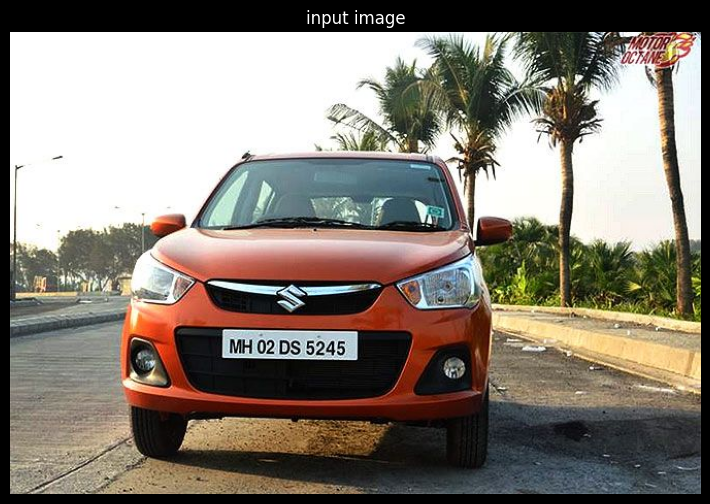

In [26]:
# Testing the above function
def display(img_, title=''):
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()

img = cv2.imread('../output/image.png')
display(img, 'input image')

In [27]:
# Getting plate prom the processed image
output_img, plate = detect_plate(img)

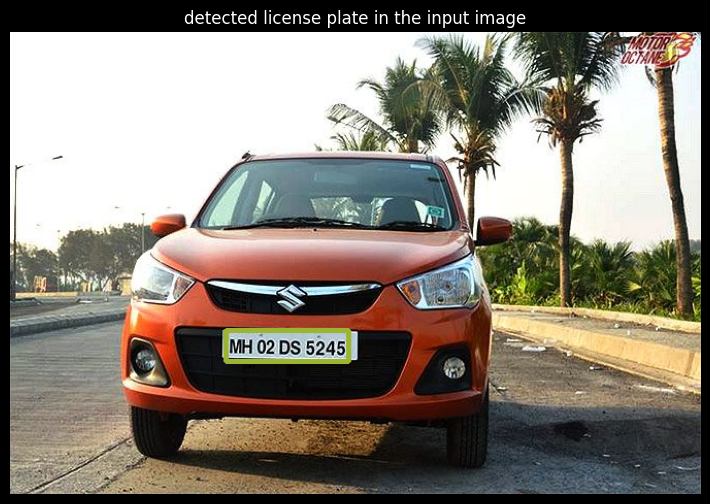

In [28]:
display(output_img, 'detected license plate in the input image')

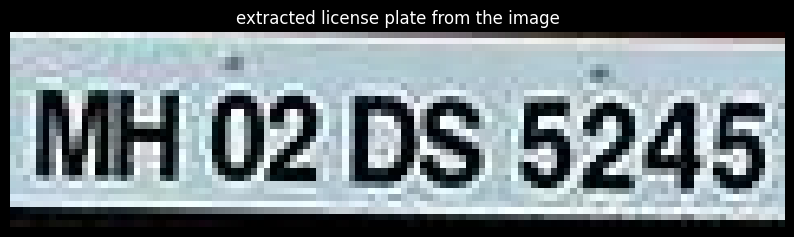

In [29]:
display(plate, 'extracted license plate from the image')

In [30]:
# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('../output/contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [50]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (0.5,0.5))
    img_binary_lp = cv2.dilate(img_binary_lp, (0.5,0.5))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('../output/contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

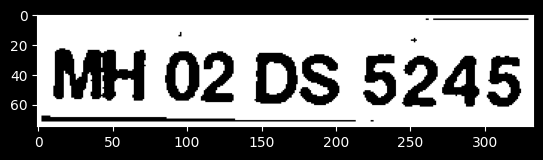

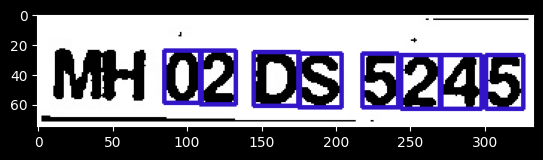

In [51]:
# Let's see the segmented characters
char = segment_characters(plate)

IndexError: index 8 is out of bounds for axis 0 with size 8

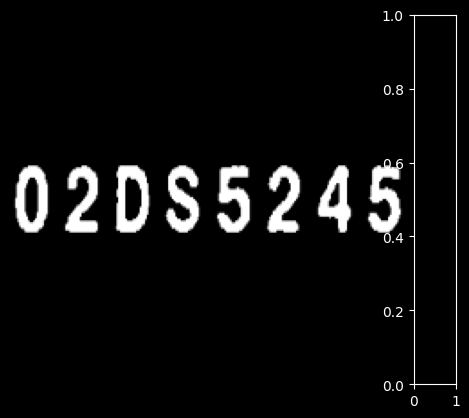

In [52]:
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')

### Model for characters

In [53]:
import tensorflow.keras.backend as K
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
path = '../data/data'
train_generator = train_datagen.flow_from_directory(
        path+'/train',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='sparse')

validation_generator = train_datagen.flow_from_directory(
        path+'/val',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28 batch_size=1,
        class_mode='sparse')

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [54]:
# Metrics for checking the model performance while training
def f1score(y, y_pred):
  return f1_score(y, tf.math.argmax(y_pred, axis=1), average='micro') 

def custom_f1score(y, y_pred):
  return tf.py_function(f1score, (y, y_pred), tf.double)

In [55]:
K.clear_session()
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

In [177]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0001), metrics=[custom_f1score])

In [178]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 14, 14, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        3

In [179]:
class stop_training_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('loss') < 0.01 or logs.get('val_custom_f1score') > 0.985):
      self.model.stop_training = True

In [180]:
batch_size = 1
callbacks = [stop_training_callback()]
# model.fit_generator(
#       train_generator,
#       steps_per_epoch = train_generator.samples // batch_size,
#       validation_data = validation_generator, 
#       epochs = 80, verbose=1, callbacks=callbacks)

history = model.fit(train_generator, steps_per_epoch=train_generator.samples // batch_size, validation_data = validation_generator, epochs=80, callbacks=callbacks)

Epoch 1/80


864/864 [==============================] - 19s 18ms/step - loss: 2.9513 - custom_f1score: 0.2581 - val_loss: 1.4023 - val_custom_f1score: 0.6354
Epoch 2/80
864/864 [==============================] - 15s 17ms/step - loss: 1.6201 - custom_f1score: 0.5532 - val_loss: 1.0430 - val_custom_f1score: 0.7083
Epoch 3/80
864/864 [==============================] - 15s 17ms/step - loss: 1.1478 - custom_f1score: 0.6586 - val_loss: 0.7118 - val_custom_f1score: 0.7932
Epoch 4/80
864/864 [==============================] - 15s 17ms/step - loss: 0.8286 - custom_f1score: 0.7627 - val_loss: 0.4330 - val_custom_f1score: 0.8512
Epoch 5/80
864/864 [==============================] - 15s 18ms/step - loss: 0.6757 - custom_f1score: 0.7894 - val_loss: 0.5762 - val_custom_f1score: 0.8125
Epoch 6/80
864/864 [==============================] - 15s 18ms/step - loss: 0.6228 - custom_f1score: 0.8079 - val_loss: 0.4147 - val_custom_f1score: 0.8557
Epoch 7/80
864/864 [==============================] - 15s 17ms/step - loss:

In [56]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Retrieve loss and F1 score history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_f1 = history.history['custom_f1score']
val_f1 = history.history['val_custom_f1score']
epochs = range(1, len(train_loss) + 1)

# Create subplots using GridSpec
fig = plt.figure(figsize=(12, 6))
gs = GridSpec(2, 1, figure=fig)

# Plot training and validation loss
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(epochs, train_loss, 'b-', label='Training Loss')
ax1.plot(epochs, val_loss, 'r-', label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot training and validation F1 score
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(epochs, train_f1, 'b-', label='Training F1 Score')
ax2.plot(epochs, val_f1, 'r-', label='Validation F1 Score')
ax2.set_title('Training and Validation F1 Score')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('F1 Score')
ax2.legend()

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

# Save the plot as image
fig.savefig('../output/training_performance.png')




NameError: name 'history' is not defined

In [182]:
# Save the model weights after training
# model.save_weights('license_plate_model_weights.h5')

In [183]:
model.save_weights('../weights/license_plate_detector.pt')

In [184]:
model.load_weights('../weights/license_plate_model_weights.h5')

In [185]:
# Predicting the output
def fix_dimension(img): 
  new_img = np.zeros((28,28,3))
  for i in range(3):
    new_img[:,:,i] = img
  return new_img
  
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model
        y_ = model.predict(img)[0] #predicting the class

        y_scalar = np.argmax(y_)
        character = dic[y_scalar] # get the class
        output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number

print(show_results())

1/1 [==============================] - 0s 37ms/step
DL8CAF5030


1/1 [==============================] - 0s 37ms/step


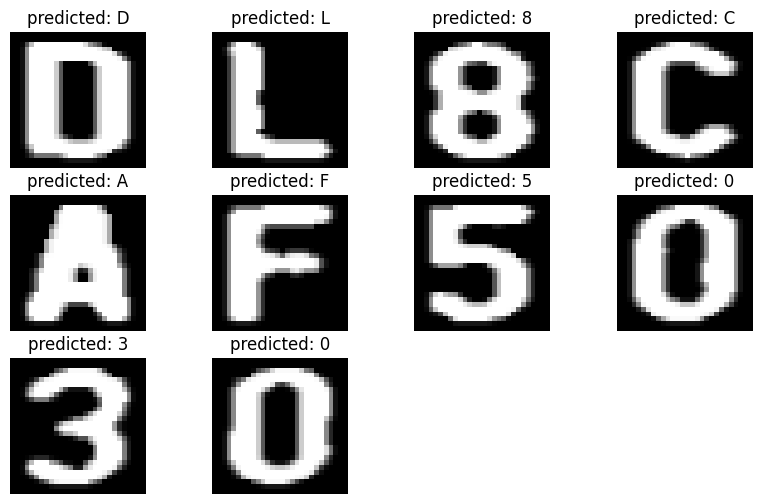

In [186]:
# Segmented characters and their predicted value.
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results()[i]}')
    plt.axis('off')
plt.show()


1/1 [==============================] - 0s 41ms/step


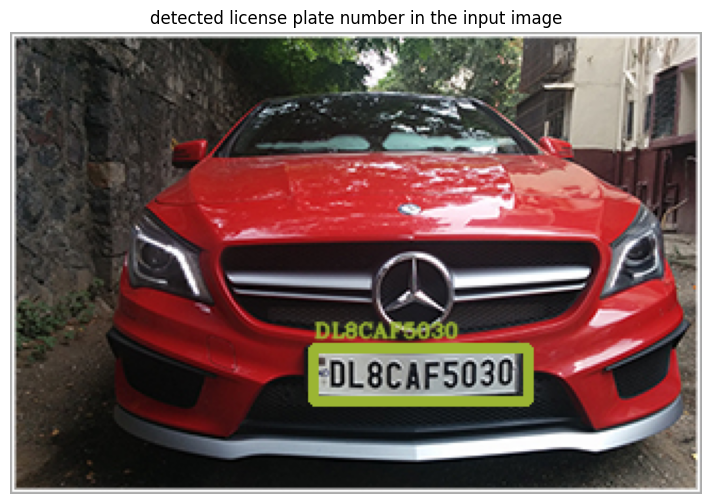

In [203]:
plate_number = show_results()
plate_number = str(plate_number)
output_img, plate = detect_plate(img, plate_number)
display(output_img, 'detected license plate number in the input image')